In [6]:
import sys

import numpy as np
from src.utilities import ChIMES, parse_xyzf
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica'] + plt.rcParams['font.sans-serif']
plt.rcParams['mathtext.it'] = 'Helvetica:italic'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize']=(2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2.0

chimes = ChIMES()

## adjustable parameters

In [7]:
kappa = 1e-5
O2b = [4, 6, 8, 10]
Oalpha = [1, 2, 3, 4, 5]

In [8]:
r = np.linspace(48.25, 120, 200)
alpha_train = np.array([3.,4.,6.,8.])
alpha_val = np.array([5, 7])
NAME = ["A3", "A4", "A6", "A8"]


r_out = r.max()
r_in = r.min()

alpha_out = alpha_train.max()
alpha_in = alpha_train.min()

morse_lambda = 60
morse_fo = 0.75

kj2kcal = 1/4.184

## load data 

In [9]:
r_arr = []
pmf_arr = []
alpha_arr = []

for a in alpha_train:
    pmf_data, particle_data = parse_xyzf(f"../../test_suite-lsq/OS-CG_PGNs/data/A{int(a)}_2b.xyzf", 2)
    r_total = np.linalg.norm(particle_data[:, 0, :] - particle_data[:, 1, :], axis=1)

    r_arr.append(r_total)
    pmf_arr.append(pmf_data)
    alpha_arr.append(np.ones_like(r_total) * a)

In [10]:
pmf_arr = np.hstack(pmf_arr)
r_arr = np.hstack(r_arr)
alpha_arr = np.hstack(alpha_arr)
print(pmf_arr.shape)

(1766,)


## calculate ground truth

In [11]:
x, x_in, x_out = chimes.morse_trans(r_arr, r_in, r_out, morse_lambda)
s_r = chimes.rescale_into_s(x, x_in, x_out)

s_alpha = chimes.rescale_into_s(alpha_arr, alpha_in, alpha_out)

In [12]:
tersoff = chimes.tersoff_smooth(r_arr, morse_fo, r_out)

Text(-0.05, 0.5, '$W^\\mathrm{OS\\text{-}CG}$ (kcal/mol)')

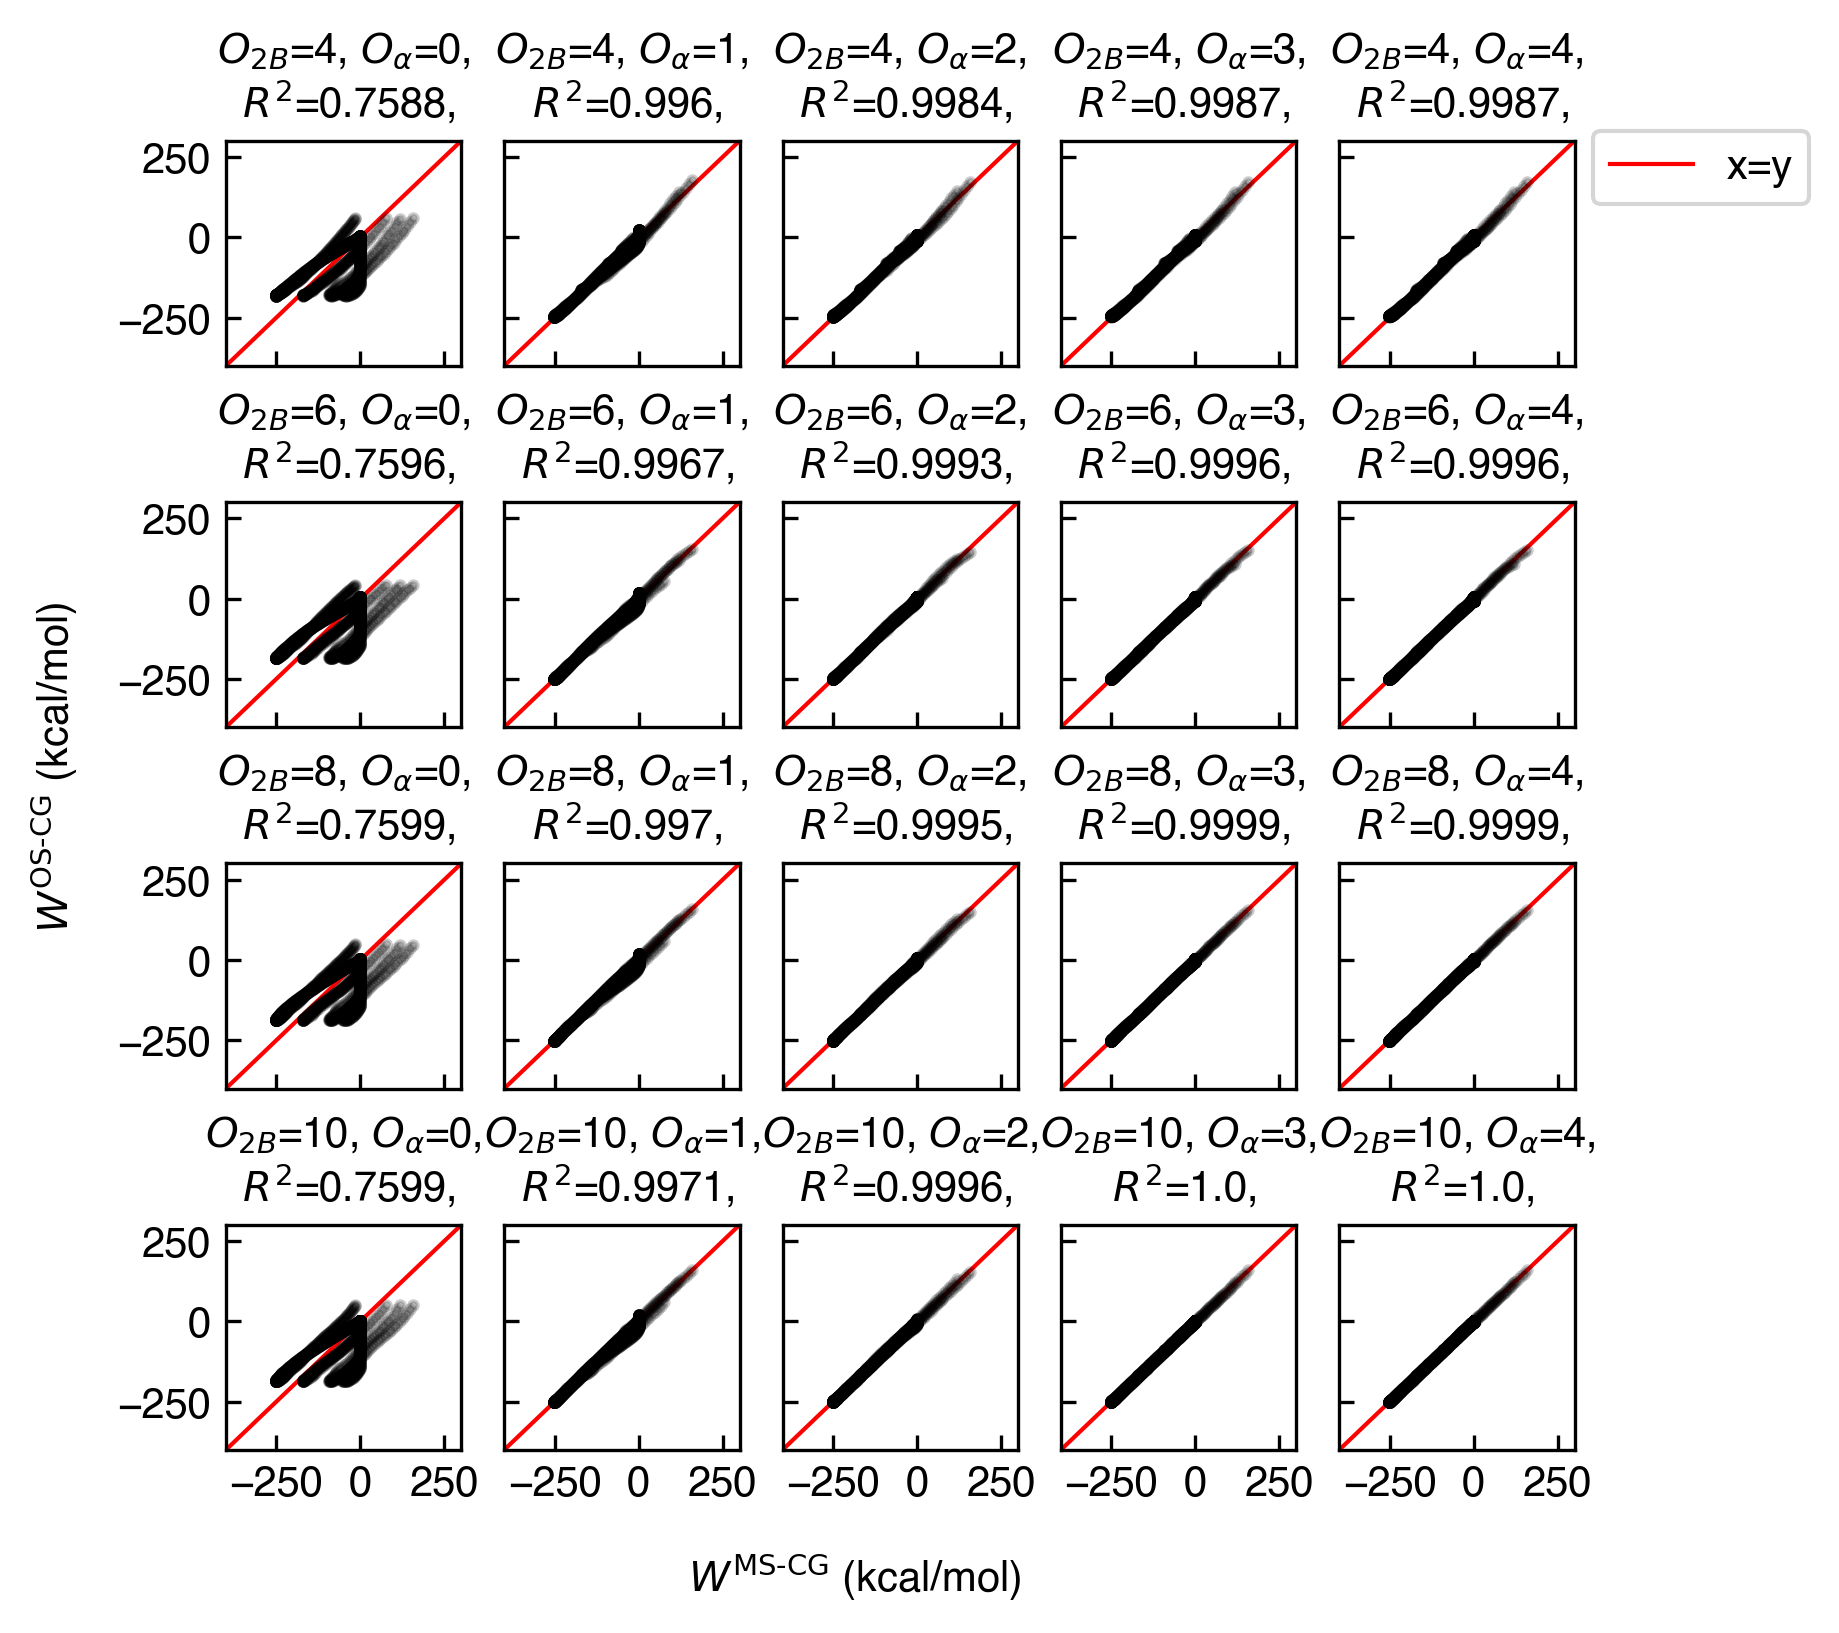

In [13]:
order_arr = []
c_arr = []
A_arr = []
pmf_pred_arr = []
rmse_arr = []
pearson_corr_arr = []

fig, axs = plt.subplots(len(O2b), len(Oalpha), sharex=True, sharey=True, layout="constrained", figsize=(5, 5))
for i, order_r in enumerate(O2b):
    for j, order_a in enumerate(Oalpha):
        A = chimes.make_Amatrix_design(s_r, order_r, s_alpha, order_a, tersoff, 2)
        c, _, ss, _ = chimes.solve_LSQ_SVD(A, pmf_arr, svd_regularization_ratio=kappa, if_return_svd_results=True)
        pmf_pred = A @ c
        pearson_correl = np.corrcoef([pmf_arr, pmf_pred])[0, 1]
        rmse = np.sqrt(np.mean((pmf_pred - pmf_arr) ** 2))

        order_arr.append((order_r, order_a))
        c_arr.append(c)
        A_arr.append(A)
        pmf_pred_arr.append(pmf_pred)
        rmse_arr.append(rmse)
        pearson_corr_arr.append(pearson_correl)

        x = pmf_arr*kj2kcal
        y = pmf_pred*kj2kcal
        
        sca = axs[i, j].scatter(x, y, color="k", marker='o', alpha=0.2, zorder=2)
        line = axs[i, j].plot([-1, 1], [-1, 1], color="r", transform=axs[i, j].transAxes, zorder=1, label="x=y")
        axs[i, j].set_title(
            r"$O_{2B}$" + f"={order_r}, " + r"$O_{\alpha}$"+f"={order_a-1}," + f"\n $R^{2}$={np.round(pearson_correl, 4)},",
        )
        axs[i, j].set_xlim([-400.0, 300.0])
        axs[i, j].set_ylim([-400.0, 300.0])
        axs[i, j].tick_params(axis='both', which='major', direction="in")

# Take the last figure to plot legend (they share the same legend anyway)
fig.legend(
    *axs[-1, -1].get_legend_handles_labels(), 
    bbox_to_anchor=(0.15, 0.438, 1.0, 0.5),  # (x, y, width, height)
) 

fig.text(0.5, -0.05, r'$W^\mathrm{MS\text{-}CG}$ (kcal/mol)', ha='center')
fig.text(-0.05, 0.5, r'$W^\mathrm{OS\text{-}CG}$ (kcal/mol)', va='center', rotation='vertical')

In [14]:
order_idx = 13
c_2b = c_arr[order_idx] 
print(c_2b.shape)
np.savez("chimes_da_c_2b.npz", c_2b = c_2b)

(33,)


In [15]:
data = np.load("chimes_da_c_2b.npz")
test = data["c_2b"]
print(test)

[-453.16029656  790.65795333    8.47301145  215.62585145 -187.5326417
  110.64461075  -92.77528603   44.63059917 -916.97142356  914.90655193
 -484.15519783  248.02378349 -233.28064431  195.14220715  -83.7527866
   28.64975606  -89.46139019  123.29686436 -109.3987655    18.51865872
   52.64315409  -23.93898161   -6.80596419    3.24869538  -13.27260069
  -38.29299732   32.17527765  -60.219709     92.18185514  -99.30714789
   59.53316585  -14.24370823  -10.52987351]


## create scan A matrix

In [16]:
r_scan = np.linspace(r_in, r_out, 50)
lamb_scan = np.linspace(alpha_in, 8, 50)
R, A = np.meshgrid(r_scan, lamb_scan)

In [17]:
R = R.ravel()
A = A.ravel()
x, x_in, x_out = chimes.morse_trans(R, r_in, r_out, morse_lambda)
s_R = chimes.rescale_into_s(x, x_in, x_out)
s_A = chimes.rescale_into_s(A, alpha_in, alpha_out)

scan_tersoff = chimes.tersoff_smooth(R, morse_fo, r_out)

In [18]:
COLOR_RMSE_MAX = 400
COLOR_RMSE_MIN = -400

contour_level = np.linspace(COLOR_RMSE_MIN, COLOR_RMSE_MAX, 10)
colorbar_ticks = np.linspace(COLOR_RMSE_MIN, COLOR_RMSE_MAX, 11)
norm = mpl.colors.Normalize(vmin=COLOR_RMSE_MIN, vmax=COLOR_RMSE_MAX)

Text(-0.05, 0.5, '$\\alpha$')

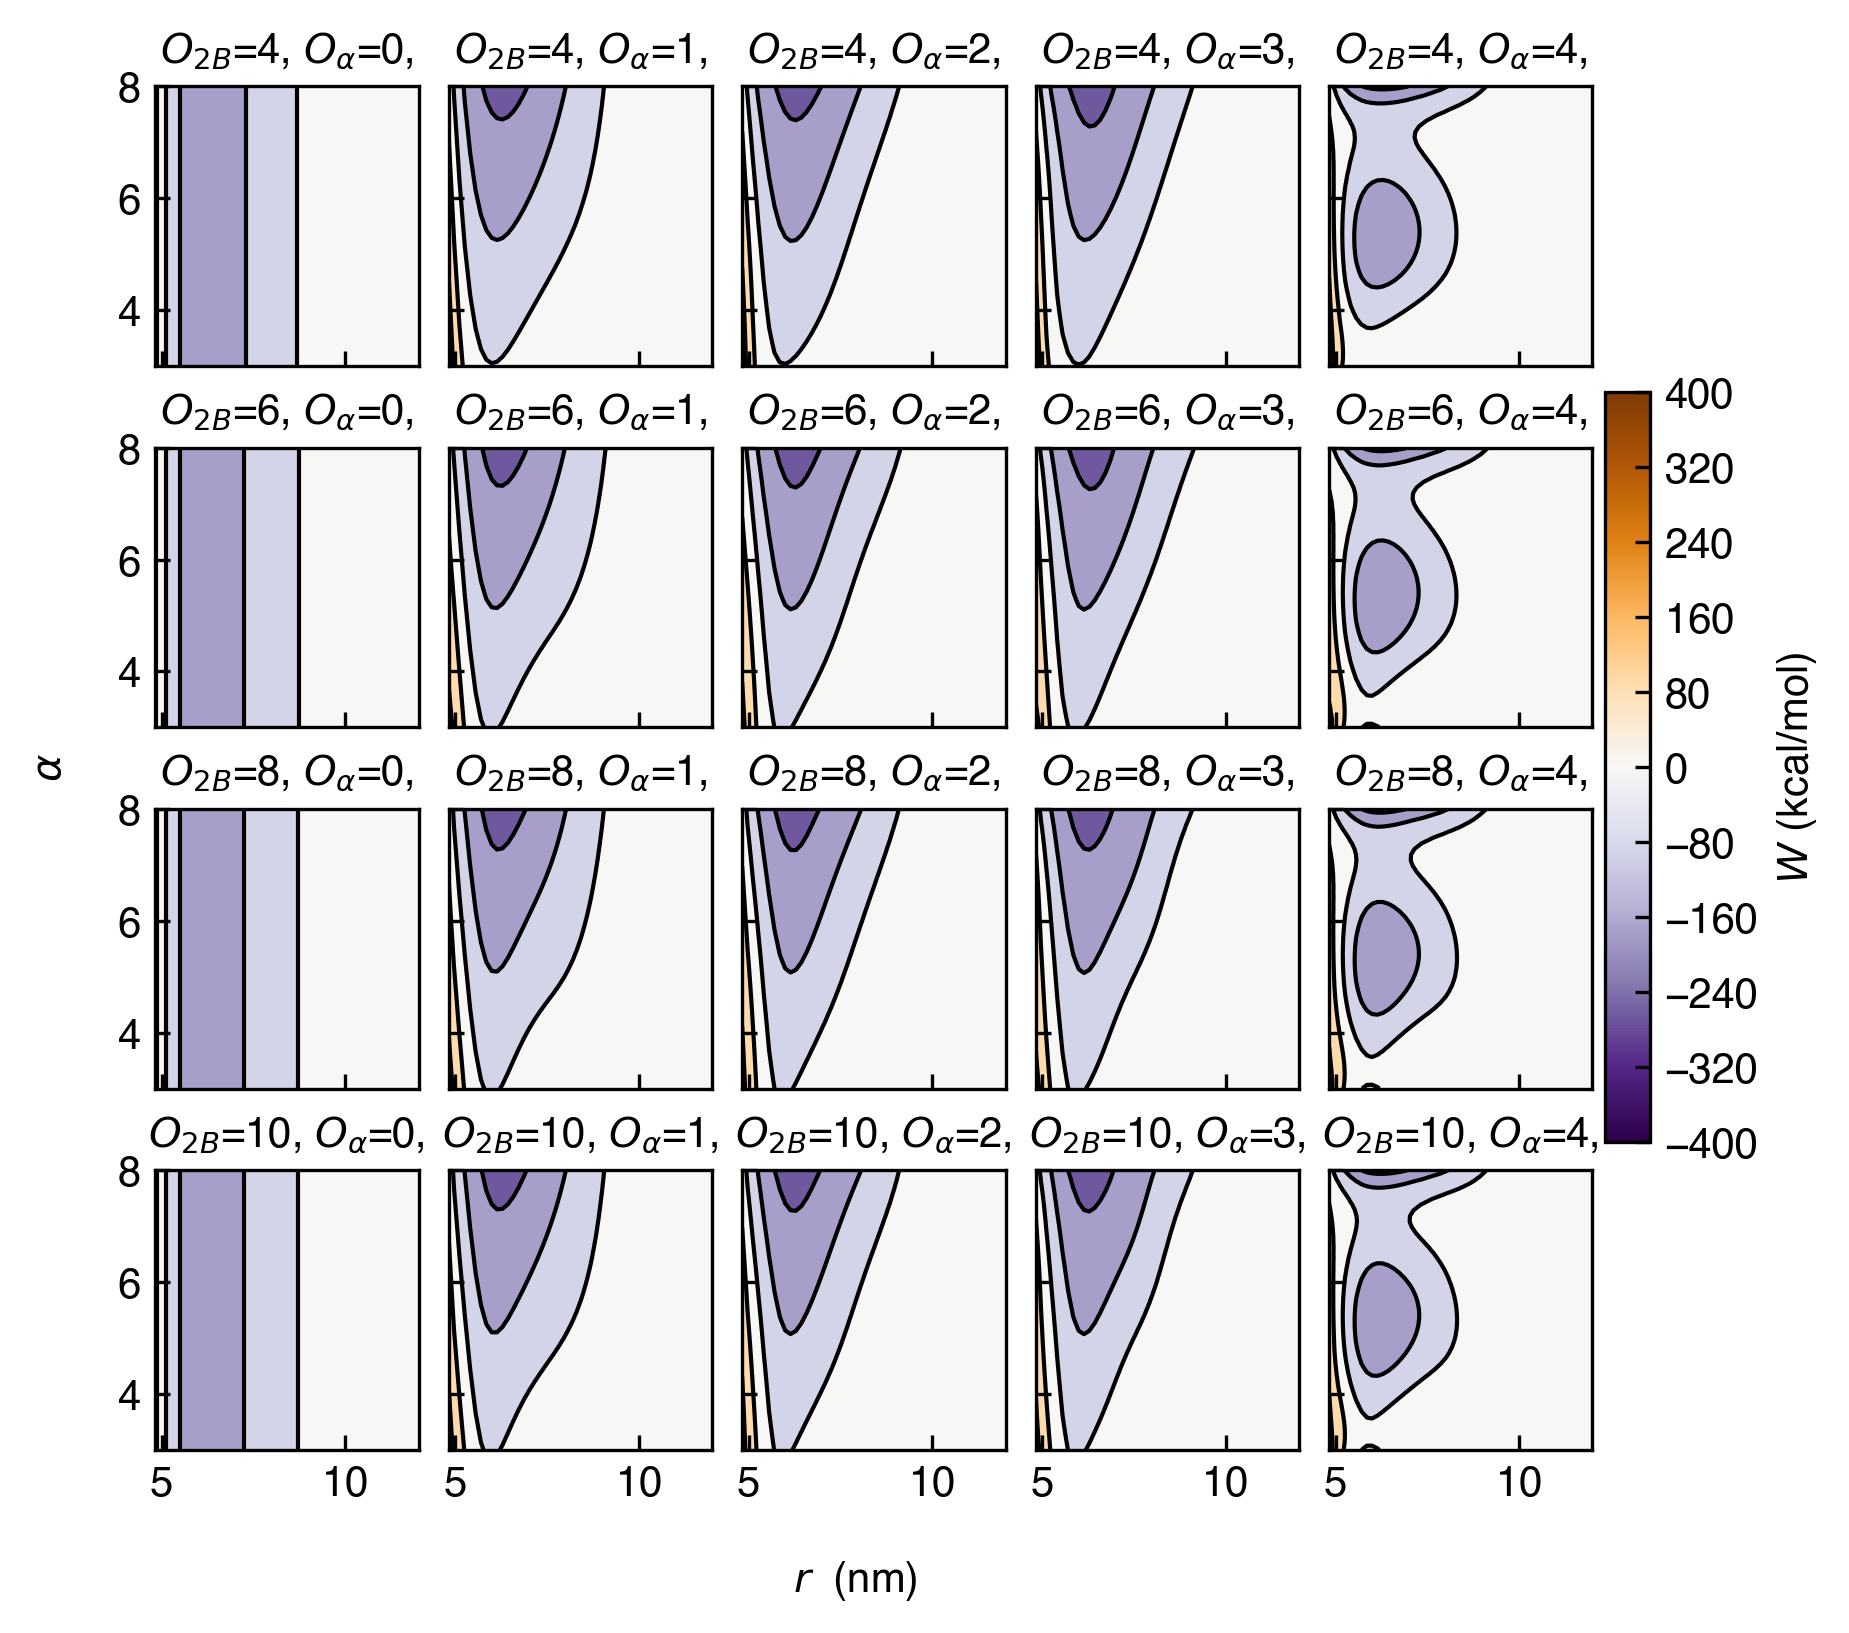

In [19]:
scan_order_arr = []
scan_c_arr = []
scan_A_arr = []
scan_pmf_pred_arr = []
fig, axs = plt.subplots(len(O2b), len(Oalpha), figsize=(5,5), sharex=True, sharey=True, layout="constrained")
for i, order_r in enumerate(O2b):
    for j, order_a in enumerate(Oalpha):
        scan_A = chimes.make_Amatrix_design(s_R, order_r, s_A, order_a, scan_tersoff, 2)
        c = c_arr[i*len(Oalpha)+j]
        pmf_pred = scan_A @ c

        scan_order_arr.append((order_r, order_a))
        scan_c_arr.append(c)
        scan_A_arr.append(scan_A)
        scan_pmf_pred_arr.append(pmf_pred)

        axs[i, j].tricontour(
            R / 10.0,
            A,
            pmf_pred*kj2kcal,
            levels=contour_level,
            linewidths=1,
            colors='k',
            linestyles='solid',
        )
        cntr = axs[i, j].tricontourf(
            R / 10.0,
            A,
            pmf_pred*kj2kcal,
            levels=contour_level,
            norm=norm,
            cmap="PuOr_r",
        )
        axs[i, j].set_title(
            r"$O_{2B}$" + f"={order_r}, " + r"$O_{\alpha}$"+f"={order_a-1},"
        )
        axs[i, j].tick_params(direction="in")

# Take the last contour map to plot colorbar (doesn't matter which one to choose since they are plotted in the same scale)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cntr.cmap)
sm.set_array([])
cbar_ax = fig.add_axes([1.0, 0.25, 0.03, 0.5])  #[left, bottom, width, height]
cbar = fig.colorbar(sm, ticks=colorbar_ticks, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(direction="in")
cbar.set_label(label=r"$W$ (kcal/mol)", weight='bold')

fig.text(0.5, -0.05, r'$r\;$ (nm)', ha='center')
fig.text(-0.05, 0.5, r'$\alpha$', va='center', rotation='vertical')

In [21]:
r_arr = []
pmf_val_arr = []
alpha_arr = []

for a in alpha_val:
    pmf_data, particle_data = parse_xyzf(f"../../test_suite-lsq/OS-CG_PGNs/data/A{int(a)}_2b.xyzf", 2)
    r_total = np.linalg.norm(particle_data[:, 0, :] - particle_data[:, 1, :], axis=1)

    r_arr.append(r_total)
    pmf_val_arr.append(pmf_data)
    alpha_arr.append(np.ones_like(r_total) * a)   

In [22]:
pmf_val_arr = np.hstack(pmf_val_arr)
r_arr = np.hstack(r_arr)
alpha_arr = np.hstack(alpha_arr)
print(pmf_val_arr.shape)

(454,)


In [23]:
## calculate ground truth
x, x_in, x_out = chimes.morse_trans(r_arr, r_in, r_out, morse_lambda)
s_r = chimes.rescale_into_s(x, x_in, x_out)

s_alpha = chimes.rescale_into_s(alpha_arr, alpha_in, alpha_out)
tersoff = chimes.tersoff_smooth(r_arr, morse_fo, r_out)

Validation RMSE= 31.288207361040673
Validation R^2= 0.9947690754904686


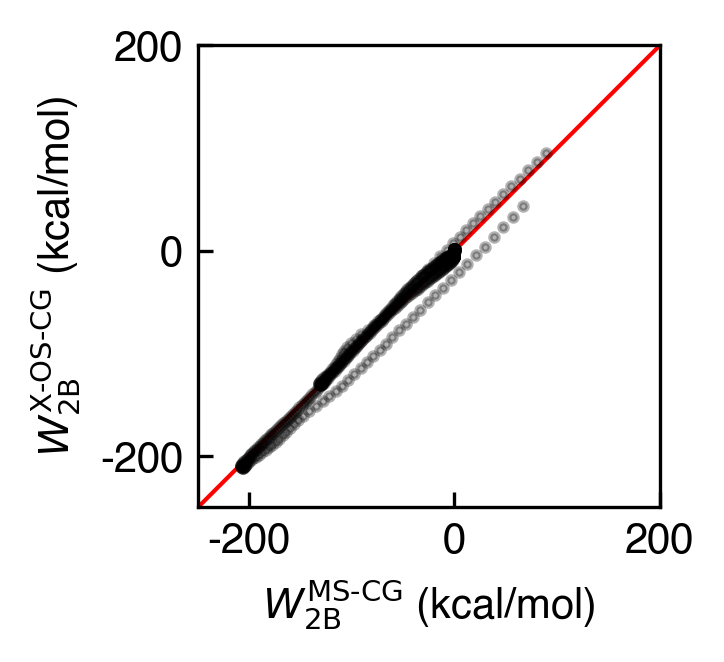

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        
A = chimes.make_Amatrix_design(s_r, order_arr[order_idx][0], s_alpha, order_arr[order_idx][1], tersoff, 2)
pmf_val_pred = A @ c_arr[order_idx]

rmse = np.sqrt(np.mean((pmf_val_pred - pmf_val_arr) ** 2))
pearson_correl = np.corrcoef([pmf_val_pred, pmf_val_arr])[0, 1]
print("Validation RMSE=", rmse)
print("Validation R^2=", pearson_correl)

ax.set_aspect('equal', 'box')
ax.plot([-1, 1], [-1, 1], color="r", transform=ax.transAxes, zorder=1)
ax.scatter(pmf_val_arr/4.184, pmf_val_pred/4.184, alpha=0.3, c="k", zorder=2)
ax.set_xlabel(r"$W^\mathrm{MS\text{-}CG}_\mathrm{2B}$ (kcal/mol)")
ax.set_ylabel(r"$W^\mathrm{X\text{-}OS\text{-}CG}_\mathrm{2B}$ (kcal/mol)")
ax.set_xlim([-250.0, 200.0])
ax.set_ylim([-250.0, 200.0])
ax.set_xticks([-200, 0, 200], labels=[-200, 0, 200])
ax.set_yticks([-200, 0, 200], labels=[-200, 0, 200])
ax.tick_params(axis="both", direction="in")